In [7]:
!pip install git+https://github.com/fastai/fastai_dev > /dev/null

  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-ikuyena9


In [72]:
import numpy as np
import fastai2
import torch
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import pydicom
import feather

In [13]:
path = '/media/keil/baltar/intracranial-hemorrhage-detection-data/'
path_trn = '/media/keil/baltar/intracranial-hemorrhage-detection-data/stage_1_train_images/'
path_tst = '/media/keil/baltar/intracranial-hemorrhage-detection-data/stage_1_test_images/'

In [19]:

df_lbls = feather.read_dataframe('./labels.fth')
df_tst = feather.read_dataframe('./df_tst.fth')
df_trn = feather.read_dataframe('./df_trn.fth')

In [20]:
comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
assert not len(comb[comb['any'].isna()])

In [21]:
comb.head().T

,0,1,2,3,4
SOPInstanceUID,ID_71fa15682,ID_36e082057,ID_36f7f598f,ID_b34f8061e,ID_bbe87874d
Modality,CT,CT,CT,CT,CT
PatientID,ID_0ce53feb,ID_aa6a68bd,ID_c8c30baf,ID_3c4bab8c,ID_6587401a
StudyInstanceUID,ID_901c2a645f,ID_e0facea27b,ID_75960f44c5,ID_7a50278155,ID_8343c31c69
SeriesInstanceUID,ID_f14ee13c33,ID_540118cb45,ID_e799c303a0,ID_55c03039bf,ID_86ea1d2868
StudyID,,,,,
ImagePositionPatient,-125,-108,-104,-126.409,-125
ImageOrientationPatient,1,1,1,1,1
SamplesPerPixel,1,1,1,1,1
PhotometricInterpretation,MONOCHROME2,MONOCHROME2,MONOCHROME2,MONOCHROME2,MONOCHROME2


In [22]:
repr_flds = ['BitsStored','PixelRepresentation']
comb.pivot_table(values=['img_mean','img_max','img_min','PatientID','any'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count','any':'mean'})

PatientID       any  img_max    img_mean  \
BitsStored PixelRepresentation                                             
12         0                       330327  0.126641     4095  450.991049   
           1                         2252  0.337034     2047 -639.221155   
16         1                       341679  0.159539    32767   55.947723   

                                img_min  
BitsStored PixelRepresentation           
12         0                          0  
           1                      -2048  
16         1                     -32768

In [23]:
comb.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=repr_flds,
                   aggfunc={'mean','max','min','std','median'})

RescaleIntercept                               \
                                            max         mean  median     min   
BitsStored PixelRepresentation                                                 
12         0                                1.0 -1023.135178 -1024.0 -1024.0   
           1                                0.0     0.000000     0.0     0.0   
16         1                                0.0 -1015.155956 -1024.0 -1024.0   

                                          RescaleSlope                        \
                                      std          max mean median  min  std   
BitsStored PixelRepresentation                                                 
12         0                    20.040220          1.0  1.0    1.0  1.0  0.0   
           1                     0.000000          1.0  1.0    1.0  1.0  0.0   
16         1                    94.752889          1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                          \
                                        max       mean median   min   
BitsStored PixelRepresentation                                        
12         0                          650.0  37.946925   36.0  25.0   
           1                          350.0  49.009769   40.0  40.0   
16         1                          800.0  34.076297   30.0  25.0   

                                          WindowWidth                     \
                                      std         max        mean median   
BitsStored PixelRepresentation                                             
12         0                    19.219504      4095.0   85.180503   80.0   
           1                    48.157162      4000.0  182.309059   80.0   
16         1                    21.021467      3000.0  104.533656   80.0   

                                                  
                                 min         std  
BitsStored PixelRepresentation                    
12         0                    26.0  128.366392  
           1                    80.0  611.029963  
16         1                    60.0  105.059073

In [40]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = [df1,df2,df3]

In [27]:
def distrib_summ(t):
    plt.hist(t,40)
    return np.array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

array([ -376,   878,  1324,  1776,  2779,  4095,  5947, 28517, 32767])

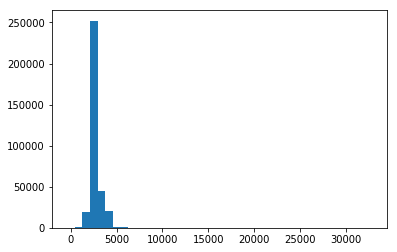

In [28]:
distrib_summ(df3.img_max.values)

array([-32768,  -3024,  -2000,  -2000,  -2000,      0,      0,      1,
           23])

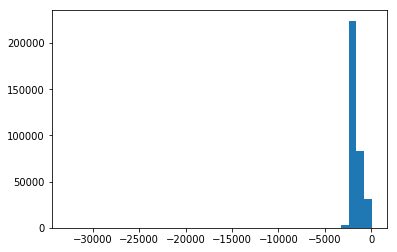

In [29]:
distrib_summ(df3.img_min.values)

array([   25,   792,  1321,  1907,  2773,  4095,  4095,  7554, 32765])

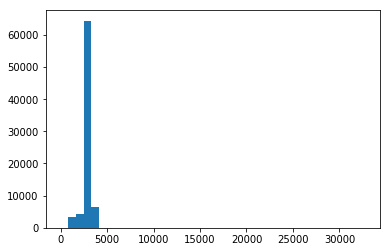

In [30]:
distrib_summ(df_tst.img_max.values)

In [46]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = [df1,df2,df3]

In [50]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

df1_sample_fns = get_samples(df1)
df2_sample_fns = get_samples(df2)
df3_sample_fns = get_samples(df3)

In [59]:
df123 = df1_sample_fns.tolist() + df2_sample_fns.tolist() + df3_sample_fns.tolist()
df123

['../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_3546389de.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_7e54f5328.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_63eb7a3ff.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_2bc64261a.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_39c0fe685.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_1b52411fd.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_682804631.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_743555355.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_0521a637b.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_cc8b6ded4.dcm',
 '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_c0c777995.dcm',
 '../input

In [87]:
sample_dcms = (fastai2.core.Path(o).dcmread() for o in df123)

In [88]:
samples = torch.stack(tuple(sample_dcms.attrgot('scaled_px')))
samples.shape

AttributeError: 'generator' object has no attribute 'attrgot'

In [114]:
paths = '/media/keil/baltar/intracranial-hemorrhage-detection-data/stage_1_train_images/'
# xxx = np.dstack([pydicom.dcmread(paths+img.split('/')[-1]).pixel_array for img in df123])

samples = torch.stack(tuple(torch.tensor([np.array(pydicom.dcmread(paths+img.split('/')[-1]).pixel_array, dtype=float) for img in df123]))




SyntaxError: unexpected EOF while parsing (<ipython-input-114-0d76ddfe50b7>, line 6)

In [116]:
type(samples)

numpy.ndarray

In [105]:
samples = np.rollaxis(xxx, 2, 0)  

In [117]:
samples.shape

(21, 512, 512)

In [108]:
bins = samples.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

AttributeError: 'numpy.ndarray' object has no attribute 'freqhist_bins'

In [130]:
def freqhist_bins(n_bins=100):
    imsd = view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

In [ ]:
torch.stack(tuple(torch.tensor([ for img in df123]))

In [131]:
for img in df123:
    print(paths+img.split('/')[-1])
    img = np.array(pydicom.dcmread(paths+img.split('/')[-1]).pixel_array, dtype=float)
    img = torch.tensor(img)
    print(img.shape)
    print(type(img))
    bins = freqhist_bins(img)

/media/keil/baltar/intracranial-hemorrhage-detection-data/stage_1_train_images/ID_3546389de.dcm
torch.Size([512, 512])
<class 'torch.Tensor'>


NameError: name 'view' is not defined